#### User Selections

In [1]:
chrom = 1#'X' 
region_idx = 0 
sample_dir = '../diffusion_v1/sampling_small/'
milestone = 69#120 
cond_scales = [float(k) for k in range(1,6)]#11)]
rescaled_phis = [k/10 for k in range(1,11)]

#### Imports

In [2]:
import torch 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset

#### Support Functions

In [3]:
def load_sample(
    directory,
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom,
):
    if directory != '' and directory[-1] != '/':
        directory+= '/'
        
    fp = f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
    
    return Sample(data=pd.read_pickle(fp).batch)

In [4]:
def get_exp_map(region_idx,exp_hic,emb_idx,interp_nans=True): 

    # Get the region information from the embedding index used during sample generation
    region_length, chrom, start = emb_idx[region_idx]
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

In [5]:
def get_best_rc_sigma(
    gen_sample,
    exp_probs,
    r_cs = torch.arange(1.5,2.5,.05).tolist(),
    sigmas = torch.arange(2,6,.25).tolist()
):
    
    best_pcc = -2
    best_r_c = 0 
    best_sigma = 0 
    best_map = None
    for r_c in r_cs: 
        for sigma in sigmas: 
            gen_probs = gen_sample.contact_probabilities(r_c=r_c,sigma=sigma)
            pcc = gen_probs.pcc(exp_probs) 
            if pcc > best_pcc: 
                best_map = gen_probs
                best_r_c = r_c 
                best_sigma = sigma
                best_pcc = pcc
    
    return best_map,r_c,sigma,best_pcc

In [6]:
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
def pipeline(
    chrom,
    region_idx,
    sample_dir,
    milestone,
    cond_scales,
    rescaled_phis,
    exp_hic=None,
    embedding_idx=None
):

    ########################
    # Prepare for computations
    print("Preparation",flush=True)
    
    # Use the GPU if its available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load the relevant data 
    if exp_hic is None:
        exp_hic = HiCDataset() # Interface for cooler object
    if embedding_idx is None:
        embedding_idx = pd.read_pickle(emb_fp(chrom)).index # Embeddings for the selected chromosome 
    
    # Initialize the object to hold all the data
    corrcoefs = torch.empty(len(cond_scales),len(rescaled_phis),dtype=torch.double,device=device)
    r_cs = torch.empty(len(cond_scales),len(rescaled_phis))
    sigmas = torch.empty(len(cond_scales),len(rescaled_phis))

    # Get the experimental probability map, which is used repeatedly in the loop 
    exp_probs = get_exp_map(region_idx,exp_hic,embedding_idx).to(device)
    
    ########################
    # Core Computations, etc. 
    if os.path.exists(sample_dir+f'corrcoefs_chrom_{chrom}_region_{region_idx}_milestone_{milestone}.pt'):
        temp = torch.load(sample_dir+f'corrcoefs_chrom_{chrom}_region_{region_idx}_milestone_{milestone}.pt')
        corrcoefs = temp['corrcoefs']
        r_cs = temp['r_cs'] 
        sigmas = temp['r_cs']
        cond_scales = temp['cond_scales']
        rescaled_phis = temp['rescaled_phis'] 
        temp = corrcoefs.cpu().numpy()
        temp = np.where(temp == temp.max())
        i,j = temp[0][0], temp[1][0]
        best_map = load_sample(sample_dir,region_idx,cond_scales[i],rescaled_phis[j],milestone,chrom
                              ).contact_probabilities(r_c=r_cs[i,j],sigma=sigmas[i,j])
    else:
        print("Core Computation",flush=True)
        best_map = None
        N = len(cond_scales) * len(rescaled_phis)
        n = 0
        for i,cond_scale in enumerate(cond_scales):
            for j,rescaled_phi in enumerate(rescaled_phis):
    
                # Load the sample
                gen_probs = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom)
                gen_probs.to(device)
                
                # Determine the corrcoef that best provides the best corrcoef with the sample and experimental map. 
                # Record these AND the corrcoef
                prob_map,r_cs[i,j],sigmas[i,j],corrcoefs[i,j] = get_best_rc_sigma(gen_probs,exp_probs)
    
                if corrcoefs[i,j] == corrcoefs.max(): 
                    best_map = prob_map
    
                n+= 1
                print(f'{100*n/N}% Complete')
    
                
        
        # Save the results.
        print("Saving Result",flush=True)
        torch.save(
            {
                'corrcoefs':corrcoefs.cpu(),
                'cond_scales':cond_scales,
                'rescaled_phis':rescaled_phis,
                'r_cs':r_cs,
                'sigmas':sigmas
            },
            sample_dir+f'corrcoefs_chrom_{chrom}_region_{region_idx}_milestone_{milestone}.pt'
        )

    ########################
    # Plot the relationship between cond_scale, rescaled_phi, and corrcoef
    
    # Plot
    fig = plt.matshow(corrcoefs.cpu().numpy(),vmin=-1,vmax=1,cmap='coolwarm')
    plt.colorbar(fig)

    # Make the ticklabels match the relevant values 
    fig.axes.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=False)
    
    b = rescaled_phis
    ticklabels = fig.axes.get_xticklabels()
    for tl in ticklabels[1:-1]: 
        tl.set_text(str(b[int(tl.get_position()[0])]))
    fig.axes.set_xticklabels(ticklabels)
    fig.axes.set_xlabel('Rescaled $\\phi$') 

    b = cond_scales
    ticklabels = fig.axes.get_yticklabels()
    for tl in ticklabels[1:-1]: 
        tl.set_text(str(b[int(tl.get_position()[1])]))
    fig.axes.set_yticklabels(ticklabels)
    fig.axes.set_ylabel('Conditioning Scale')

    ########################
    # Plot the true probability map and the one that best matches it
    
    # Plot the experimental Hi-C map 
    exp_probs.plot();

    # Plot the best-matching generated map
    best_map.plot();

    # Return values that may be useful in downstream analysis
    return corrcoefs, r_cs, sigmas 

    
    
            

#### Perform the comparison

In [9]:
embeddings = pd.read_pickle(emb_fp(chrom))#.index 
embedding_idx = embeddings.index

Preparation


/state/partition1/slurm_tmp/24650555.0.0/ipykernel_217573/2289370375.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_xticklabels(ticklabels)
/state/partition1/slurm_tmp/24650555.0.0/ipykernel_217573/2289370375.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes.set_yticklabels(ticklabels)


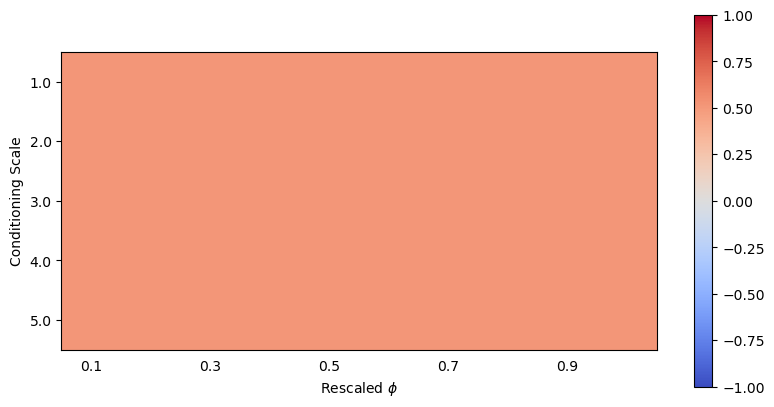

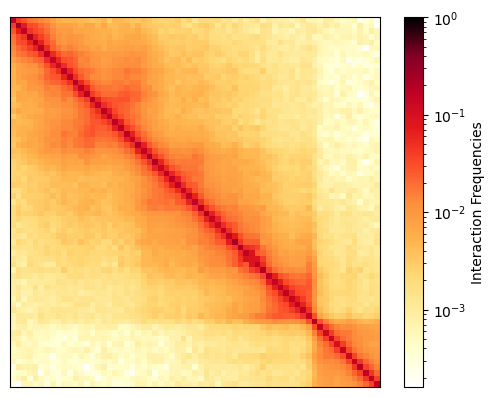

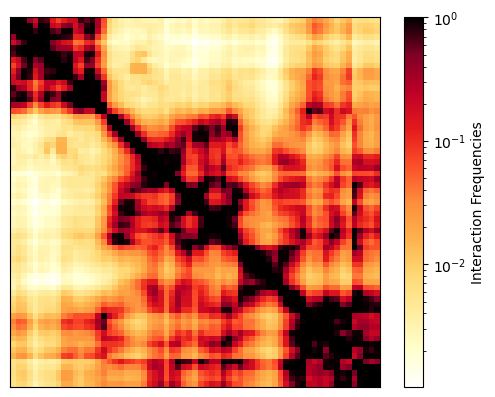

In [10]:
corrcoefs, r_cs, sigmas = pipeline(
    chrom,
    region_idx,
    sample_dir,
    milestone,
    cond_scales,
    rescaled_phis,
    exp_hic=None,
    embedding_idx=embedding_idx
)

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7ff26e120310>)

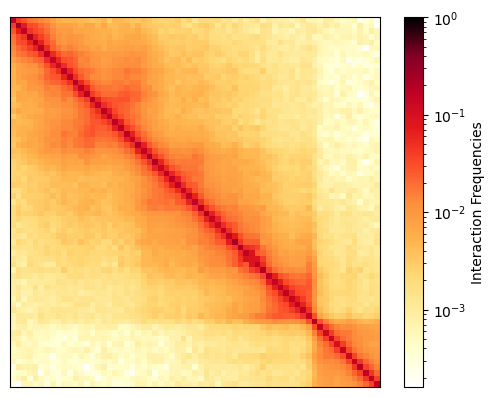

In [11]:
device = 'cuda'
exp_hic = HiCDataset()
exp_probs = get_exp_map(region_idx,exp_hic,embeddings.index).to(device)
exp_probs.plot()

(array([ 0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.]),
 array([1.95000005, 2.04999995, 2.1500001 , 2.25      , 2.35000014,
        2.45000005, 2.54999995, 2.6500001 , 2.75      , 2.85000014,
        2.95000005]),
 <BarContainer object of 10 artists>)

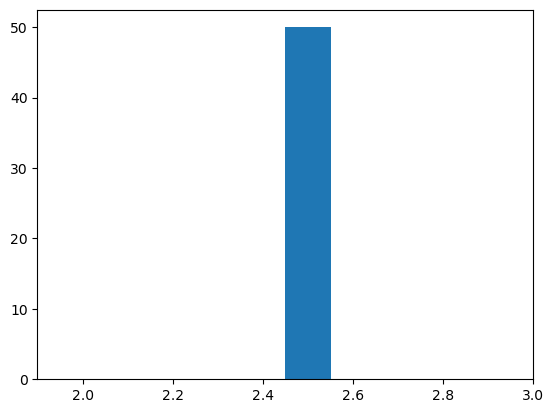

In [92]:
plt.hist(r_cs.cpu().numpy().flatten())

(array([ 0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.]),
 array([5.25      , 5.3499999 , 5.44999981, 5.55000019, 5.6500001 ,
        5.75      , 5.8499999 , 5.94999981, 6.05000019, 6.1500001 ,
        6.25      ]),
 <BarContainer object of 10 artists>)

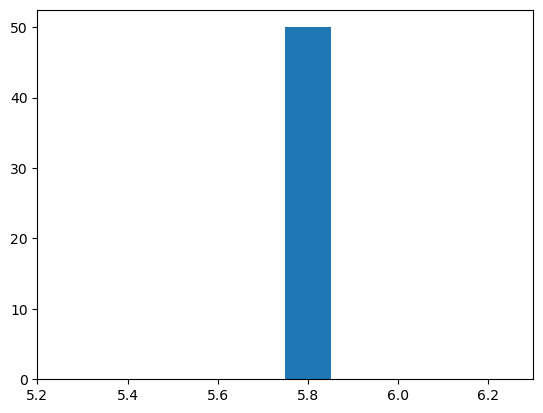

In [93]:
plt.hist(sigmas.cpu().numpy().flatten())

(array([40.,  0.,  0.,  1.,  3.,  1.,  3.,  1.,  0.,  1.]),
 array([0.50969125, 0.51017446, 0.51065768, 0.51114089, 0.5116241 ,
        0.51210731, 0.51259052, 0.51307373, 0.51355694, 0.51404016,
        0.51452337]),
 <BarContainer object of 10 artists>)

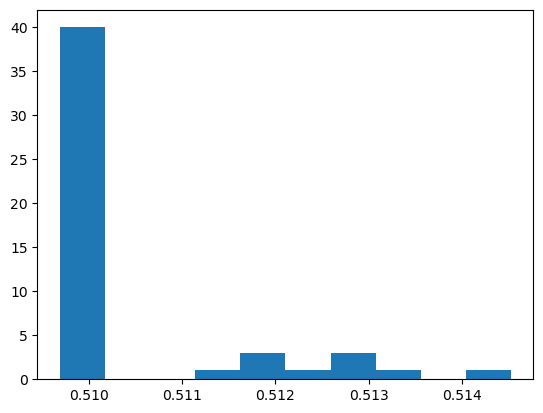

In [94]:
plt.hist(corrcoefs.flatten().cpu().numpy())

In [ ]:
asdf

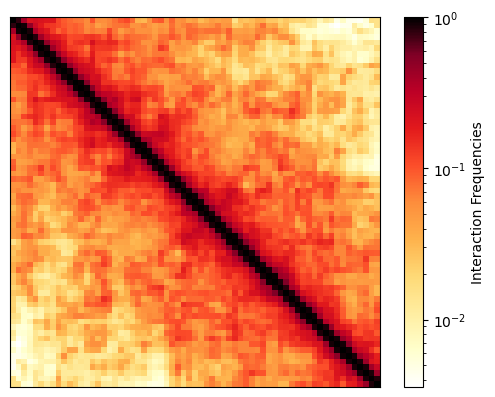

In [16]:
# From the old large model
r_c = 1.75
sigma = 4
gen_probs = load_sample(
    directory='../../data/samples/large_model/',
    region_idx=0,
    cond_scale=1,
    rescaled_phi=.2,
    milestone=96,
    chrom=1
)
gen_probs.to('cuda') 
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

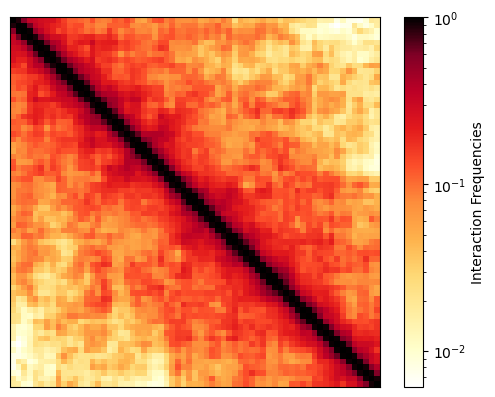

In [17]:
r_c = 2
sigma = 4
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [34]:
chrom='X'
cond_scale=1.
rescaled_phi=0.5
r_c=1.75
sigma=3

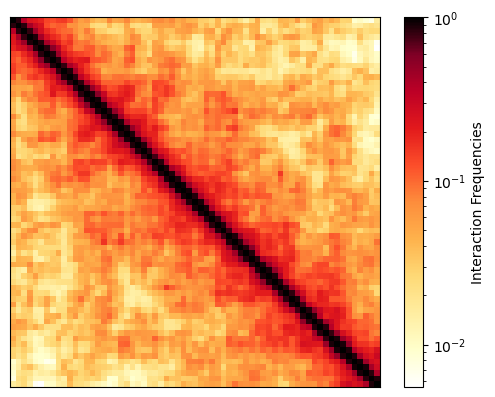

In [35]:
chrom = 1
region_idx = 0 
gen_probs = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom)
gen_probs.to('cuda') 
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [37]:
cond_scale=5.
rescaled_phi=0.5
r_c=1.75
sigma=3

sample_1 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom=1)
sample_2 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom='X')

sample_1.cuda()
sample_2.cuda()

p1 = sample_1.contact_probabilities()
p2 = sample_2.contact_probabilities()

p1.pcc(p2) 

tensor(0.9983, device='cuda:0', dtype=torch.float64)

In [43]:
sample_1.batch

tensor([[[[ 1.1753,  1.4214,  2.7200,  ...,  1.8244,  1.8289,  3.1910],
          [ 1.4253,  0.5965,  1.6701,  ...,  1.6725,  1.9463,  3.2429],
          [ 2.7154,  1.6705,  1.3469,  ...,  1.8164,  1.6805,  2.8415],
          ...,
          [ 1.8224,  1.6674,  1.8258,  ...,  1.4372,  2.5031,  3.6766],
          [ 1.7562,  1.8331,  1.5974,  ...,  2.5047,  1.3741,  2.5265],
          [ 3.1399,  3.1688,  2.8175,  ...,  3.6706,  2.5221,  1.4675]]],


        [[[ 1.2281,  1.7344,  2.4287,  ..., 10.1334, 10.5986, 10.7024],
          [ 1.7347,  1.1309,  2.8880,  ..., 10.3029, 10.9038, 11.0429],
          [ 2.4315,  2.8893,  2.4914,  ..., 10.0827, 10.6699, 10.7625],
          ...,
          [10.1283, 10.2936, 10.0769,  ...,  1.1130,  1.8883,  2.3530],
          [10.6019, 10.9028, 10.6775,  ...,  1.8882,  1.2895,  1.8351],
          [10.7146, 11.0428, 10.7541,  ...,  2.3553,  1.8361,  0.6850]]],


        [[[ 1.4278,  1.5549,  1.4367,  ...,  7.1057,  6.5380,  6.3960],
          [ 1.5567,  1.157

In [54]:
def hic_via_tanh(sample,r_c,sigma):

    sample.unnormalize_()
    r = sample.batch.clone()
    '''
    #r = self.batch.clone() # Distances
    if self.coords is None: 
        self.get_coords()

    r = torch.cdist(self.coords,self.coords)
    '''
    
    mask = r < r_c 
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )

    mask^= True 
    r[mask] = .5 * ( r_c / r[mask] )**4

    return r.mean(0).squeeze().float()#.to(self.batch_dtype) 

In [81]:
from HiCMap import pcc

sample_dir = '../diffusion_v1/sampling_small/'#'../../data/samples/small_model/'

cond_scale=1.
rescaled_phi=1.
r_c=1.75
sigma=3

#sample_1 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom=1)
#sample_2 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom='X')
sample_1 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone=38,chrom='X')
sample_2 = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone=69,chrom=1)

sample_1.cuda()
sample_2.cuda()

p1 = hic_via_tanh(sample_1,r_c,sigma)
p2 = hic_via_tanh(sample_2,r_c,sigma)
#p1 = sample_1.contact_probabilities()
#p2 = sample_2.contact_probabilities()

#p1.pcc(p2) 
pcc(p1,p2) 

tensor(0.4963, device='cuda:0')

In [82]:
from matplotlib.colors import LogNorm
import cooltools.lib.plotting # provides 'fall' colormap
def plot_hic(
    mat,
    vmin=None,
    vmax=1,
    cmap='fall'
):

    norm = LogNorm(vmin=vmin,vmax=vmax)
    #n,hic_map = self.nbins, self.prob_map
    hic_map = mat.squeeze()
    n = hic_map.shape[0] 
    extent = (0,n,n,0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    im = ax.matshow(
        hic_map.cpu().numpy(),
        norm=norm,
        cmap=cmap,
        extent=extent
    );
    ax.xaxis.set_visible(False) # don't show the arbitrary ticks
    ax.yaxis.set_visible(False) # don't show the arbitrary ticks 
    
    cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

    return fig,ax,im,cbar

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7ff1644a33d0>)

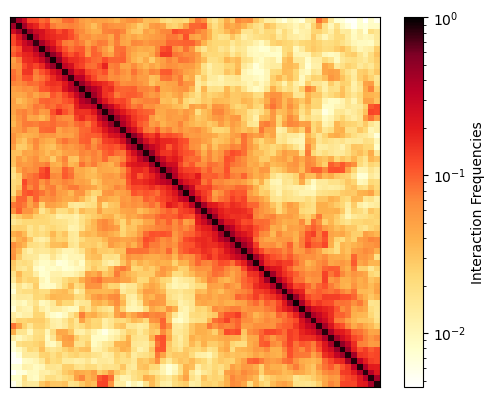

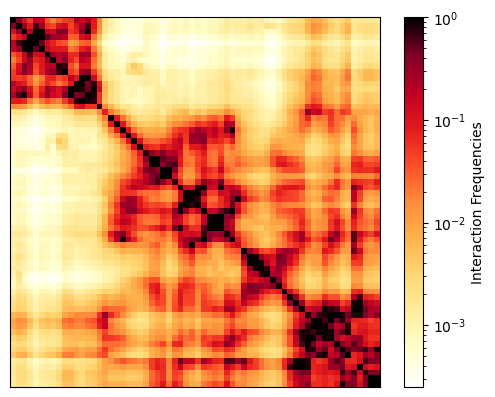

In [83]:
plot_hic(p1)
plot_hic(p2)

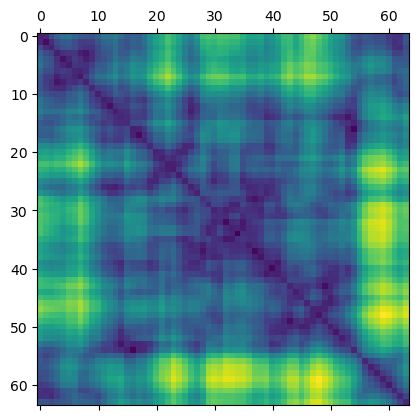

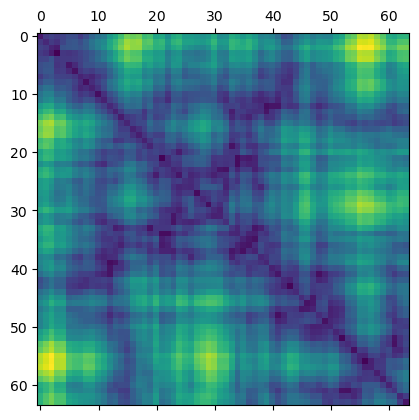

In [50]:
entry = 0 
for s in [sample_1,sample_2]: 
    plt.matshow(
        s.batch[entry,...].squeeze().cpu().numpy()
    )
    

In [ ]:
chrom = 1
region_idx = 50
gen_probs = load_sample(sample_dir,region_idx,cond_scale,rescaled_phi,milestone,chrom)
gen_probs.to('cuda') 
gen_probs.contact_probabilities(r_c=r_c,sigma=sigma).plot();

In [28]:
a = pd.read_pickle('../../data/embeddings/chrom_1.tar.gz')
b = pd.read_pickle('../../data/embeddings/chrom_X.tar.gz') 

In [29]:
print(len(a))

10774


In [30]:
print(len(b))

7271
